In [293]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np


In [311]:

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, 1, padding=1)
    
    def forward(self, x):
        return self.conv2(F.relu(self.conv1(x)))


class FutureNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 2)
    
    def forward(self, features, ref_points):
        vals = F.grid_sample(features, ref_points * 2 - 1, align_corners=False).squeeze(2).flatten(1, 2)
        x = F.relu(self.fc1(vals))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # return (x + ref_points[:, 0, 0, :]).sigmoid()
        return x.sigmoid()
    

class FullNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.part1 = ConvNet()
        self.part2 = FutureNet()
    
    def forward(self, I, refs):
        f = self.part1(I)
        return self.part2(f, refs)



In [312]:
B = 1
y = torch.rand(B, 2)
I = torch.randn(B, 3, 24, 24)

In [313]:
net = FullNet()
opt = torch.optim.Adam(net.parameters(), lr=1e-4)
refs0 = torch.rand(B, 1, 1, 2)

In [316]:
n_epochs = 5000

for epoch in range(n_epochs):
    refs = torch.rand(B, 1, 1, 2)
    preds = net(I, refs)
    loss = (y - preds).square().mean()
    opt.zero_grad()
    loss.backward()
    opt.step()

    if epoch % 100 == 0:
        print(epoch, loss.item())

0 0.0011399235809221864
100 5.5358968893415295e-06
200 0.00036103196907788515
300 8.569395868107677e-05
400 0.0005767354741692543
500 0.0003526628133840859
600 2.0258881704648957e-05
700 0.00013506652612704784
800 8.267701196018606e-05
900 0.0002505261800251901
1000 0.0001429486583219841
1100 8.285168587462977e-05
1200 9.905898878059816e-06
1300 4.105053812963888e-05
1400 0.0003040993178728968
1500 2.4136064894264564e-05
1600 5.715899897040799e-05
1700 3.2506504794582725e-05
1800 6.517047586385161e-05
1900 2.698077878449112e-06
2000 3.337282578286249e-06
2100 2.216995562775992e-05
2200 8.210990017687436e-06
2300 3.513423280310235e-06
2400 2.8946962629561312e-05
2500 5.104746378492564e-06
2600 1.146870999946259e-05
2700 0.00019290411728434265
2800 4.4102518586441875e-05
2900 9.15026703296462e-06
3000 3.1012118597573135e-06
3100 0.00012729575973935425
3200 3.4076997508236673e-06
3300 3.509831731207669e-05
3400 2.0828167180297896e-05
3500 1.1186322808498517e-05
3600 4.781923780683428e-05


In [303]:
preds

tensor([[0.3226, 0.2187]], grad_fn=<SigmoidBackward0>)

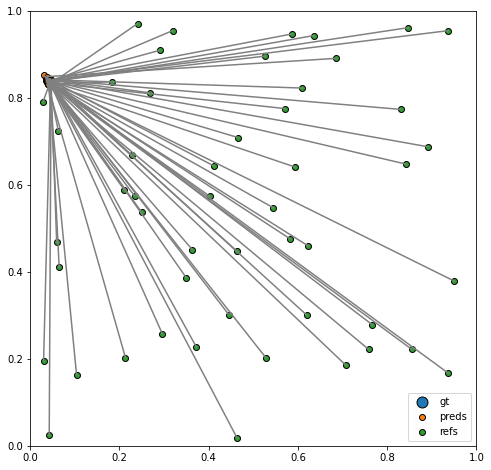

In [317]:
if y.size(0) == 1:
    N = 50
    refs2 = torch.rand(N, 1, 1, 2)
    preds_ = net(I.repeat(N, 1, 1, 1), refs2)

    plt.figure(figsize=(8, 8))
    plt.scatter(y[0, 0], y[0, 1], s=120, edgecolors='k', label='gt')
    plt.scatter(preds_[..., 0].detach(), preds_[..., 1].detach(), edgecolors='k', label='preds')
    plt.scatter(refs2[..., 0].detach(), refs2[..., 1].detach(), edgecolors='k', label='refs')

    for i in range(refs2.size(0)):
        plt.plot( [refs2[i, 0, 0, 0], preds_[i, 0].detach(), y[0, 0]], 
                [refs2[i, 0, 0, 1], preds_[i, 1].detach(), y[0, 1]], color='grey', )
    plt.legend()
    plt.xlim([0, 1])
    plt.ylim([0, 1])

else:
    plt.figure(figsize=(8, 8))
    plt.scatter(y[..., 0], y[..., 1], s=120, edgecolors='k', label='gt')
    plt.scatter(preds[..., 0].detach(), preds[..., 1].detach(), edgecolors='k', label='preds')
    plt.scatter(refs0[..., 0].detach(), refs0[..., 1].detach(), edgecolors='k', label='refs')

    for i in range(y.size(0)):
        plt.plot( [refs0[i, 0, 0, 0], preds[i, 0].detach(), y[i, 0]], 
                [refs0[i, 0, 0, 1], preds[i, 1].detach(), y[i, 1]], color='grey', )
    plt.legend()
    plt.xlim([0, 1])
    plt.ylim([0, 1])

In [66]:
preds.size()

torch.Size([25, 25, 2])

In [225]:
preds.size()

torch.Size([10, 2])